<a href="https://colab.research.google.com/github/AnnaMalmgren/deep_learning_birdsong_classification/blob/main/project_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Train and Evaluate Models

### Anna Malmgren 
This is a colab file for the final project in the course Deep Learning - metoder och tillämpningar, held by Umeå University. 

**Other colab files for the project:**  
[Data Exploration](https://colab.research.google.com/drive/1XhDb5psoArmqCB3sgI4TEZuG6NXtI3GU?usp=sharing)

[Feature Extraction](https://colab.research.google.com/drive/1BWXWWo-2qeFOg6EQBF3Rf_CKa69Ed1s5?usp=sharing)


To run the code in this colab file, make sure you've generated and downloaded the datasets using the feature extraction colab file linked above. 


## Install and Import dependencies and files


In this section needed dependencies are installed and imported. Then the melspectrogram zip folder (generated in the Feature Extraction Colab file) is uploaded, as well as the train_data.csv, val_data.csv, and test_data.csv (also generated in the Feature Extraction Colab file). Finally the mel spectrogram zip folder is extracted. 

In [ ]:
# install tensorflow_addons to access the F1 metric
! pip install tensorflow_addons


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 34.1 MB/s 
     |████████████████████████████████| 97 kB 2.8 MB/s 


In [ ]:
# Import dependencies

import numpy as np
import pandas as pd
from tensorflow.keras import models, layers, callbacks
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import tensorflow_addons as tfa

from PIL import Image 

# Dependencies for vizualisation
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Dependencies for file handling
from pathlib import Path
import os
import glob


Keras Tuner version: 1.0.4


In [ ]:
# Before running this file the colab file 
# https://colab.research.google.com/drive/1BWXWWo-2qeFOg6EQBF3Rf_CKa69Ed1s5?usp=sharing
# Should have been used to generate and download the needed zip folder and csv files

from google.colab import files

files.upload() # upload melspectograms.zip 
files.upload() # upload train_data.csv
files.upload() # upload val_data.csv
files.upload() # upload test_data.csv



Saving melspectograms (1).zip to melspectograms (1).zip


Saving train_data (1).csv to train_data (1).csv


Saving val_data (1).csv to val_data (1).csv


Saving test_data (1).csv to test_data (1).csv


{'test_data (1).csv': b'data_x,data_y\n/content/dataset/melspectograms/Sylvia communis/Sylvia-communis-201152_40.jpg,5\n/content/dataset/melspectograms/Strix aluco/Strix-aluco-243925_96.jpg,11\n/content/dataset/melspectograms/Sonus naturalis/Sonus-naturalis-448679_315.jpg,0\n/content/dataset/melspectograms/Sonus naturalis/Sonus-naturalis-448679_237.jpg,0\n/content/dataset/melspectograms/Turdus philomelos/Turdus-philomelos-169606_24.jpg,4\n/content/dataset/melspectograms/Carduelis carduelis/Carduelis-carduelis-357700_54.jpg,13\n/content/dataset/melspectograms/Sonus naturalis/Sonus-naturalis-330799_239.jpg,0\n/content/dataset/melspectograms/Carduelis carduelis/Carduelis-carduelis-298510_123.jpg,13\n/content/dataset/melspectograms/Erithacus rubecula/Erithacus-rubecula-448670_73.jpg,14\n/content/dataset/melspectograms/Sonus naturalis/Sonus-naturalis-373438_200.jpg,0\n/content/dataset/melspectograms/Carduelis carduelis/Carduelis-carduelis-263694_60.jpg,13\n/content/dataset/melspectograms/Er

In [ ]:
# unzip mel spectrograms zip folder to path /content/dataset/melspectograms

!unzip 'melspectograms.zip' -d '../'

Utdata för streaming har trunkerats till de sista 5000 raderna.
 extracting: ../content/dataset/melspectograms/Erithacus rubecula/Erithacus-rubecula-448670_161.jpg  
 extracting: ../content/dataset/melspectograms/Erithacus rubecula/Erithacus-rubecula-477536_68.jpg  
 extracting: ../content/dataset/melspectograms/Erithacus rubecula/Erithacus-rubecula-212969_46.jpg  
 extracting: ../content/dataset/melspectograms/Erithacus rubecula/Erithacus-rubecula-210422_33.jpg  
 extracting: ../content/dataset/melspectograms/Erithacus rubecula/Erithacus-rubecula-155712_53.jpg  
 extracting: ../content/dataset/melspectograms/Erithacus rubecula/Erithacus-rubecula-514130_6.jpg  
 extracting: ../content/dataset/melspectograms/Erithacus rubecula/Erithacus-rubecula-448670_239.jpg  
 extracting: ../content/dataset/melspectograms/Erithacus rubecula/Erithacus-rubecula-155712_26.jpg  
 extracting: ../content/dataset/melspectograms/Erithacus rubecula/Erithacus-rubecula-234111_20.jpg  
 extracting: ../content/da

## Constants and Functions for Dataset Generation. 

This sections defines needed constants as well as functions needed for the dataset generation. 

In [ ]:
# Bird Species labels are found in the Feature extraction colab file. 

CLASS_NAMES =  ['Sonus naturalis',
                'Fringilla coelebs',
                'Parus major',
                'Turdus merula',
                'Turdus philomelos',
                'Sylvia communis',
                'Emberiza citrinella',
                'Sylvia atricapilla',
                'Emberiza calandra',
                'Phylloscopus trochilus',
                'Luscinia megarhynchos',
                'Strix aluco',
                'Phylloscopus collybita',
                'Carduelis carduelis',
                'Erithacus rubecula']
                
CLASSES = len(CLASS_NAMES)

# Adding F1-scores to metrics as the dataset is unbalanced. 
DEFAULT_METRICS = [tfa.metrics.F1Score(average=None, name='f1_score', num_classes=CLASSES),
                   tfa.metrics.F1Score(average='weighted', name='weighted_f1', num_classes=CLASSES),
                  'accuracy']

# Defining training constants to be used when training the models
MAX_EPOCHS = 100
BATCH_SIZE = 32

ES = callbacks.EarlyStopping(monitor='val_loss', patience=4, verbose=1, mode='auto', restore_best_weights=True)
RL = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1, mode='auto')

# Variables for the datasets            
df_train = pd.read_csv('/content/train_data.csv')
df_val = pd.read_csv('/content/val_data.csv')
df_test = pd.read_csv('/content/test_data.csv')


In [ ]:

def to_images(data):
  """
  Opens the given image files as single channel images.

  Parameters:
  data: iterable containing the image file paths as strings. 

  Returns:
  Numpy array containing the image data, as a singel channel images. 
  """
  return [np.array(Image.open(file).convert('L')) for file in data]

def normalize_data(data, labels):
  """
  Normalizes the image data. 

  Parameters:
  data: tensor containing the image data
  labels: tensor containing the labels for the image data. 

  Returns
  The normalized image data tensor, and the labels tensor. 
  """
  data = (tf.cast(data, tf.float32) / 255.0)
  return data, labels
 
def expand_dims(data, labels):
  """
  Adds the color channel to the image data. 

  Parameters:
  data: tensor containing the image data
  labels: tensor containing the labels for the image data. 

  Returns
  The image data tensor, with the added color channel, and the labels tensor.  
  """
  return tf.expand_dims(data, -1), labels

def encode_labels(labels):
  """
  Uses keras to_categorical method to one hot encode the labels.

  Parameters:
  labels: array containing the labels (represented as integers)

  Returns:
  Binary matrix representing the labels. 
  """
  return to_categorical(labels, num_classes=CLASSES)

def to_rgb(data, labels):
  """
  Converts grayscale image data to rgb

  Parameters:
  data: tensor containing the greyscale image data
  labels: tensor containing the labels for the image data. 

  Returns:
  The rgb image data tensor, and the labels tensor
  """
  return tf.image.grayscale_to_rgb(tf.convert_to_tensor(data)), labels

def dataset_pipeline(images, labels):
  """
  Generates the dataset of given images and labels. 
  
  Parameters:
  images: array containing the image data 
  labels: array containing the one hot encoded labels. 

  Returns:
  TensorFlow PrefetchDataset containing the image data and the labels. 
  """
  dataset = tf.data.Dataset.from_tensor_slices((images, labels))

  dataset = (dataset
             .map(expand_dims, num_parallel_calls=tf.data.experimental.AUTOTUNE )
             .map(normalize_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)
             .cache()
             .batch(32)
             .prefetch(tf.data.experimental.AUTOTUNE)
             )
  return dataset

def plot_images(dataset, nrows=2, ncols=4, figsize=[12, 6], save=False):
  """
  Plots n-rows and n-cols of images. 

  Parameters:
  dataset: Tensorflow PrefetchDataset containing the image data and its labels. 
  nrow: number of rows to plot. Default 2. 
  ncolums: number of columns to plot. Default 4. 
  figsize: array of figure length and height. Default [12, 6]
  save: boolean, saves and download the plotted images if True. Default False. 

  """         
  index = 0
  images = []
  labels = []

  # Extract the wanted number of images and their
  # respective class (bird species)
  for set in dataset:
    if (index >= (nrows * ncols)): break
    img, label = set
    label_index = tf.argmax(label[index])
    images.append(img[index])
    labels.append(CLASS_NAMES[label_index])
    index += 1

  fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    
  # plot the images and their labels
  for i, axi in enumerate(ax.flat):
    img = images[i]
    axi.imshow(img[:,:,0])    
    axi.set_title(labels[i])

  plt.tight_layout(True)

  # save and download image if save is set to True
  if save:
   plt.savefig('mel_images.png')
   files.download(f'mel_images.png') 
  plt.show()

def plot_training(epochs, history, model_name):
  """
  Plot the training and validation macro F1-score, weighted F1-score and loss.

  Parameters:
  epochs: integer representing number of epochs run. 
  history: Keras Callbacks History object, containing the models training history. 
  model_name: string represented the model's name. 
  """
  epochrange = range(1, epochs + 1)
  
  # Calculate the macro F1-score using the F1-scores calculated for each class. 
  train_f1 = [np.transpose(row).mean() for row in history.history['f1_score']]
  val_f1 = [np.transpose(row).mean() for row in history.history['val_f1_score']]
  
  # Variables for weighted F1-scores and loss. 
  train_w_f1 = history.history['weighted_f1']
  val_w_f1 = history.history['val_weighted_f1']
  train_loss = history.history['loss']
  val_loss = history.history['val_loss']

  # plot chart for macro F1-score, weighted F1-score, and loss. 
  plot_data(epochrange, train_f1, val_f1, 'F1 Score', model_name)
  plot_data(epochrange, train_w_f1, val_w_f1, 'Weighted F1 Score', model_name)
  plot_data(epochrange, train_loss, val_loss, 'Loss', model_name)

def plot_data(x, y_t, y_v, data_type, model_name):
  """
  Helper function for plot_training to plot given data using matplotlib.pyplot. 

  Parameters:
  x: array representing the epoch range.
  y_t: array of the training y data (f1-scores or loss)
  y_v: array of validation y data (f1-scores or loss)
  model_name: string representing the name of the model. 
  """
  plt.plot(x, y_t, 'bo', label=f'Training {data_type}')
  plt.plot(x, y_v, 'b', label=f'Validation {data_type}')
  plt.title(f'Training and validation {data_type} {model_name}')
  plt.xlabel('Epochs')
  plt.ylabel(data_type)
  plt.legend() 
  plt.show()



## Generate Datasets

First the uploaded mel spectrogram images are transformed to single channel image data, and the labels are transformed to binary matrices. Then the dataset is generate using a pipeline for TensorFlow Dataset, and returned as a TensorFlow PrefetchDataset. Finally some example mel spectrogram images are plotted to make sure that they still looks ok. 

In [ ]:
# generate single channel image data using the image paths.
X_train = to_images(df_train['data_x'].values)
X_val = to_images(df_val['data_x'].values)
X_test = to_images(df_test['data_x'].values)

# generate one hot encoded labels
Y_train = encode_labels(df_train['data_y'].values)
Y_val = encode_labels(df_val['data_y'].values)
Y_test = encode_labels(df_test['data_y'].values)

In [ ]:
# generate the dataset as Tensorflow PrefetchDataset

train_data = dataset_pipeline(X_train, Y_train)
val_data = dataset_pipeline(X_val, Y_val)
test_data = dataset_pipeline(X_test, Y_test)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

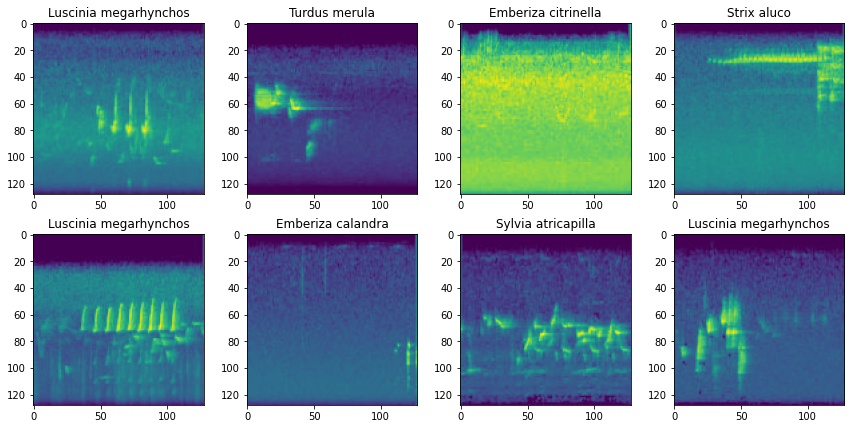

In [ ]:
# plot some of the images to make sure they look ok.
plot_images(train_data)

## Define functions for creating models and training. 

This section defines the needed functions for creating model instances, training, and evaluation. 

In [ ]:
def simple_CNN(input_shape):
  """
  Generates the simple CNN model. 

  Parameters:
  input_shape: the shape of the models input

  Returns: 
  The simple CNN model
  """
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))
  model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
  model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dropout(0.3))
  model.add(layers.Dense(CLASSES, activation='softmax'))
  return model


def larger_CNN(input_shape):
  """
  Generates the larger CNN model. 

  Parameters:
  input_shape: the shape of the models input

  Returns: 
  The larger CNN model
  """
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))
  model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
  model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
  model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dropout(0.3))
  model.add(layers.Dense(CLASSES, activation='softmax'))
  return model

def baseline_RCNN(input_shape):
    """
    Generates the RCNN (CNN-LSTM) model. 

    Parameters:
    input_shape: the shape of the models input

    Returns: 
    The simple RNN (CNN-LSTM) model
    """
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Permute((2, 1, 3)))
    model.add(layers.TimeDistributed(layers.Flatten()))

    model.add(layers.LSTM(128, dropout=0.25, return_sequences=True))
    model.add(layers.LSTM(128, dropout=0.25))
    model.add(layers.Dense(CLASSES, kernel_regularizer=tf.keras.regularizers.l2(0.0001), activation='softmax'))
    return model

def xception (input_shape, trainable=False, include_top=False, weights='imagenet'):
  """
  Calls Keras.applications.Xception and sets all the layers to non-trainable. 

  Parameters: 
  input_shape: the shape of the models input
  include_top: whether or not to include Xception's top. Default False.
  weights: string representing the Xception wheights to use. Default imagenet. 

  Returns:
  The Xception model.
  """
  xception_model = tf.keras.applications.Xception(weights = weights, 
                                                include_top = include_top,
                                                input_shape = input_shape)
  # Freeze layers in the Xception model
  for layer in xception_model.layers:
    layer.trainable = trainable
    
  return xception_model


def compile(model, metrics, 
            optimizer='adam', 
            loss='categorical_crossentropy'):
  """
  Compiles the given model and shows the models summary. 

  Parameters:
  model: the model instance to compile.
  optimizer: string representing the optimizer to use. Default adam. 
  loss: string representing the loss function to use. 
        Default categorical_crossentropy.
  
  Returns: 
  The compiled model. 
  """
      
   model.compile(optimizer=optimizer,loss=loss, metrics=metrics)
   model.summary()
   return model   

def fit_model(model,
              training_data,
              validation_data, 
              epochs=MAX_EPOCHS, 
              batch_size=BATCH_SIZE,
              callbacks=[RL, ES]):
  """
  Trains the given model using given data. 

  Parameters: 
  model: the model instance to train.
  training_data: TensorFlow PrefetchDataset containing the training data
  validation_data: TensorFlow PrefetchDataset containing the validation data. 
  epochs: Max number of epochs to run. Default 100.
  batch_size: The batch size for the training. Default 32. 
  callbacks: array containing the callbacks for training. 
             Default contains ReducedLROnPlateau and EarlyStopping
  
  Returns:
  The History object created by the training. 
  """
  
  return model.fit(training_data,
                   epochs=epochs, 
                   batch_size=batch_size,
                   callbacks=callbacks,
                   validation_data=validation_data)


## Simple CNN

This section creates an instance of The simple CNN model, performs the training process, and evaluates the model.  


---


**Simple CNN Summary:**   
Conv2D(filters=32, kernel_size=(3, 3), padding= 'same')  
Conv2D(filters=32, kernel_size=(3, 3), padding= 'same')  
Batch Normalization  
MaxPooling2D(pool_size=(2, 2))  
Conv2D(filters=64, kernel_size=(3, 3), padding= 'same')  
Conv2D(filters=64, kernel_size=(3, 3), padding= 'same')  
Batch Normalization  
MaxPooling2D(pool_size=(2, 2))  
Flatten
Dense(units=128, activation='relu')  
Dropout(rate=0.3)  
Dense(units=15, activation='softmax')  


---


**Evaluation:**  
Loss: 0.8170    
Macro F1-score: 0.7165  
Weighted F1: 0.7868  
Accuracy: 0.7902  



In [ ]:
# Create and compile a simple CNN model instance

input_shape = train_data.element_spec[0].shape

simple_CNN = simple_CNN(input_shape[1:])
simple_CNN = compile(simple_CNN, DEFAULT_METRICS)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 128, 128, 32)      320       
                                                                 
 conv2d_5 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 batch_normalization_2 (Batc  (None, 128, 128, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 64, 64)       

In [ ]:
# Train the model 

simple_CNN_history = fit_model(simple_CNN, train_data, val_data)               

Epoch 1/100
563/563 [==============================] - 42s 45ms/step - loss: 2.7813 - f1_score: 0.0669 - weighted_f1: 0.1581 - accuracy: 0.2844 - val_loss: 2.2900 - val_f1_score: 0.0725 - val_weighted_f1: 0.1660 - val_accuracy: 0.3060 - lr: 0.0010
Epoch 2/100
563/563 [==============================] - 24s 42ms/step - loss: 2.3463 - f1_score: 0.0626 - weighted_f1: 0.1581 - accuracy: 0.2969 - val_loss: 45.7811 - val_f1_score: 0.0277 - val_weighted_f1: 0.0251 - val_accuracy: 0.0366 - lr: 0.0010
Epoch 3/100
563/563 [==============================] - 25s 44ms/step - loss: 2.3078 - f1_score: 0.0667 - weighted_f1: 0.1630 - accuracy: 0.3001 - val_loss: 2.1896 - val_f1_score: 0.0825 - val_weighted_f1: 0.1813 - val_accuracy: 0.3166 - lr: 0.0010
Epoch 4/100
563/563 [==============================] - 24s 43ms/step - loss: 2.1942 - f1_score: 0.0934 - weighted_f1: 0.1972 - accuracy: 0.3304 - val_loss: 4.2097 - val_f1_score: 0.0345 - val_weighted_f1: 0.0922 - val_accuracy: 0.1521 - lr: 0.0010
Epoch 5

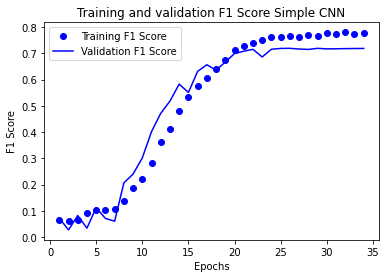

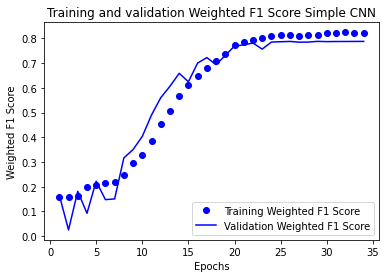

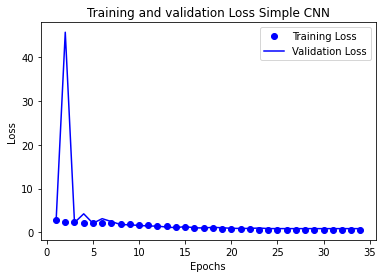

In [ ]:
# plot the training and validation macro F1-score, weighted F1-score, and loss. 

plot_training(34, simple_CNN_history, 'Simple CNN')

In [ ]:
# Evaluate the model 

simple_CNN.evaluate(test_data, return_dict=True)

141/141 [==============================] - 2s 13ms/step - loss: 0.8170 - f1_score: 0.7165 - weighted_f1: 0.7868 - accuracy: 0.7902


{'accuracy': 0.7901865243911743,
 'f1_score': array([0.9310071 , 0.44534412, 0.56088567, 0.73903   , 0.7818697 ,
        0.56777495, 0.6751269 , 0.63072777, 0.70360106, 0.65030676,
        0.8498099 , 0.9271028 , 0.7581228 , 0.81099653, 0.7161804 ],
       dtype=float32),
 'loss': 0.8169642686843872,
 'weighted_f1': 0.7867708206176758}

## Larger CNN


This section creates an instance of the larger CNN model, runs and plots the training process, and evaluates the model. 


---


**Larger CNN summary:**  
Conv2D(filters=32, kernel_size=(3, 3), padding='same')  
Conv2D(filters=32, kernel_size=(3, 3), padding='same')  
Batch Normalization  
MaxPooling2D(pool_size=(2, 2))   
Conv2D(filters=64, kernel_size=(3, 3), padding='same')  
Conv2D(filters=64, kernel:size=(3, 3), padding='same')  
Batch Normalization   
layers.MaxPooling2D(pool_size=(2, 2))  
Conv2D(filters=128, kernel_size=(3, 3), padding='same')  
Conv2D(filters=128, kernel:size=(3, 3), padding='same')  
Batch Normalization  
MaxPooling2D(pool_size=(2, 2))  
Flatten  
Dense(units=128, activation='relu')  
Dropout(rate=0.3)  
Dense(units=15, activation='softmax')  


---


**Evaluation:**  
Loss: 0.5527  
Macro F1-score: 0.8039  
Weighted F1-Score: 0.8583  
Accuracy: 0.8597

In [ ]:
# create and compile an instance of the larger CNN model. 

larger_CNN = larger_CNN(input_shape[1:])

larger_CNN = compile(larger_CNN, DEFAULT_METRICS)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 128, 128, 32)      320       
                                                                 
 conv2d_9 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 batch_normalization_4 (Batc  (None, 128, 128, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 conv2d_11 (Conv2D)          (None, 64, 64, 64)       

In [ ]:
# train the model 

history_larger_CNN = fit_model(larger_CNN, train_data, val_data)

Epoch 1/100
563/563 [==============================] - 29s 50ms/step - loss: 2.2318 - f1_score: 0.3183 - weighted_f1: 0.4307 - accuracy: 0.3614 - val_loss: 1.8892 - val_f1_score: 0.2415 - val_weighted_f1: 0.3753 - val_accuracy: 0.4159 - lr: 0.0010
Epoch 2/100
563/563 [==============================] - 28s 49ms/step - loss: 1.7915 - f1_score: 0.2403 - weighted_f1: 0.3909 - accuracy: 0.4166 - val_loss: 1.7650 - val_f1_score: 0.2639 - val_weighted_f1: 0.3902 - val_accuracy: 0.4147 - lr: 0.0010
Epoch 3/100
563/563 [==============================] - 28s 49ms/step - loss: 1.5753 - f1_score: 0.3343 - weighted_f1: 0.4747 - accuracy: 0.4904 - val_loss: 1.3696 - val_f1_score: 0.4370 - val_weighted_f1: 0.5821 - val_accuracy: 0.5981 - lr: 0.0010
Epoch 4/100
563/563 [==============================] - 28s 50ms/step - loss: 1.4128 - f1_score: 0.4049 - weighted_f1: 0.5310 - accuracy: 0.5390 - val_loss: 1.1756 - val_f1_score: 0.4815 - val_weighted_f1: 0.6009 - val_accuracy: 0.6286 - lr: 0.0010
Epoch 5/

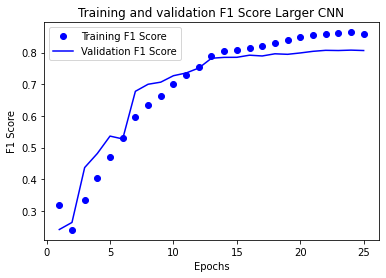

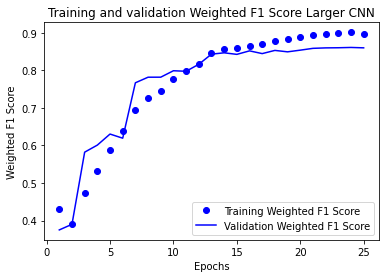

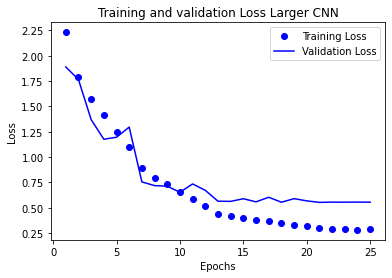

In [ ]:
# plot the training and validation macro F1-score, weighted F1-score, and loss. 

plot_training(25, history_larger_CNN, 'Larger CNN')

In [ ]:
# evaluate the model 

larger_CNN.evaluate(test_data, return_dict=True)

141/141 [==============================] - 2s 16ms/step - loss: 0.5527 - f1_score: 0.8039 - weighted_f1: 0.8583 - accuracy: 0.8597


{'accuracy': 0.8596802949905396,
 'f1_score': array([0.968775  , 0.5945946 , 0.72807014, 0.82150537, 0.8521739 ,
        0.7218935 , 0.80725616, 0.69451696, 0.80672264, 0.7136929 ,
        0.93360573, 0.9289618 , 0.8106313 , 0.8783784 , 0.797066  ],
       dtype=float32),
 'loss': 0.552681028842926,
 'weighted_f1': 0.858284592628479}

## CNN_LSTM Model

This section creates an instance of the CNN-LSTM (RCNN) model, runs and plots the training process, and evaluates the model. 


---


**CNN-LSTM summary:**  
Conv2D(filters=32, kernel_size=(3, 3), padding='same')  
Conv2D(filters=32, kernel_size=(3, 3), padding='same')  
Batch Normalization  
MaxPooling2D(pool_size=(2, 2))   
Conv2D(filters=64, kernel_size=(3, 3), padding='same')  
Conv2D(filters=64, kernel:size=(3, 3), padding='same')  
Batch Normalization   
layers.MaxPooling2D(pool_size=(2, 2))  
Conv2D(filters=128, kernel_size=(3, 3), padding='same')  
Conv2D(filters=128, kernel:size=(3, 3), padding='same')  
Batch Normalization  
MaxPooling2D(pool_size=(2, 2))    
Permute((2, 1, 3))  
TimeDistributed(Flatten)  
LSTM(units=128, dropout=0.25, return_sequences=True)  
LSTM(units=128, dropout=0.25)  
Dense(units=15, kernel_regularizer=l2(0.0001), activation='softmax')  


---



**Evaluation:**  
Loss: 0.3173  
Macro F1-score: 0.8869  
Weighted F1-score: 0.9191  
Accuracy: 0.9192

In [ ]:
# create and compile an instance of the CNN-LSTM model. 

model_RCNN = baseline_RCNN(input_shape[1:])
model_RCNN = compile(model_RCNN, DEFAULT_METRICS)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 128, 128, 32)      320       
                                                                 
 conv2d_15 (Conv2D)          (None, 128, 128, 32)      9248      
                                                                 
 batch_normalization_7 (Batc  (None, 128, 128, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_16 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 conv2d_17 (Conv2D)          (None, 64, 64, 64)       

In [ ]:
# train the model

history_RCNN = fit_model(model_RCNN, train_data, val_data)

Epoch 1/100
563/563 [==============================] - 36s 56ms/step - loss: 1.1388 - f1_score: 0.6068 - weighted_f1: 0.6835 - accuracy: 0.6520 - val_loss: 1.3561 - val_f1_score: 0.4531 - val_weighted_f1: 0.5492 - val_accuracy: 0.5688 - lr: 0.0010
Epoch 2/100
563/563 [==============================] - 31s 55ms/step - loss: 0.6531 - f1_score: 0.7454 - weighted_f1: 0.8007 - accuracy: 0.8035 - val_loss: 0.6846 - val_f1_score: 0.7362 - val_weighted_f1: 0.7953 - val_accuracy: 0.7953 - lr: 0.0010
Epoch 3/100
563/563 [==============================] - 31s 55ms/step - loss: 0.4787 - f1_score: 0.8097 - weighted_f1: 0.8540 - accuracy: 0.8550 - val_loss: 0.8327 - val_f1_score: 0.6977 - val_weighted_f1: 0.7577 - val_accuracy: 0.7591 - lr: 0.0010
Epoch 4/100
562/563 [============================>.] - ETA: 0s - loss: 0.3611 - f1_score: 0.8534 - weighted_f1: 0.8905 - accuracy: 0.8910
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
563/563 [==============================] 

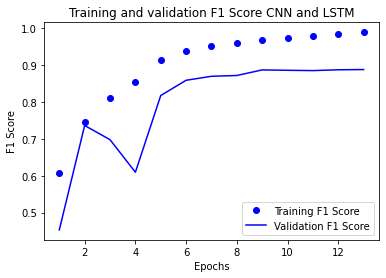

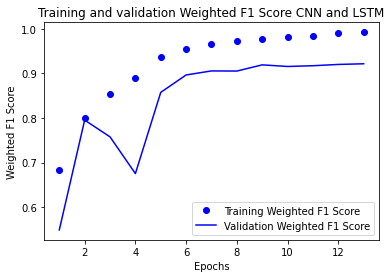

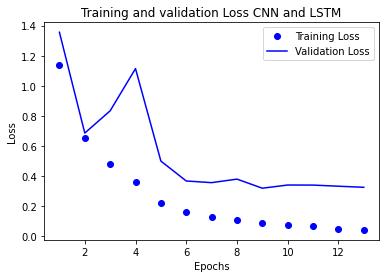

In [ ]:
# plot the training and validation macro F1-score, weighted F1-score, and loss. 

plot_training(13, history_RCNN, 'CNN and LSTM')

In [ ]:
# evaluate the model. 

model_RCNN.evaluate(test_data, return_dict=True)

141/141 [==============================] - 2s 16ms/step - loss: 0.3173 - f1_score: 0.8869 - weighted_f1: 0.9191 - accuracy: 0.9192


{'accuracy': 0.9191829562187195,
 'f1_score': array([0.98627925, 0.7972508 , 0.8583691 , 0.8926316 , 0.92284864,
        0.8636363 , 0.8683603 , 0.79115486, 0.8415584 , 0.8148148 ,
        0.9674134 , 0.9735849 , 0.88961035, 0.9267462 , 0.90956074],
       dtype=float32),
 'loss': 0.31729698181152344,
 'weighted_f1': 0.9191223978996277}

## Xception Transfer Learning

First the image data is converted to rgb as the Xception model requires three channels. 

Then an  Xception transfer learning model, connected to two dense layers is defined (called X-Base): 


---


**X-Base**  
Xception Layer Output  (for best performance *block5_sepconv3_bn*)  
Batch Normalization    
Dense(units=128, activation='relu')  
Batch Normalization   
Dropout(rate=0.5)   
Dense(units=15, activation='softmax')   


---


Next an Xception transfer learning model, connected to two LSTM is defined (called X-LSTM):


---



**X-LSTM**   
Xception Layer Output (for best performance *block3_pool*)  
Batch Normalization  
MaxPooling2D(pool_size=(2, 2))  
Permute((2, 1, 3))  
TimeDistributed(layers.Flatten())  
LSTM(units=128, dropout=0.25, return_sequences=True)  
LSTM(units=128, dropout=0.25)  
Dense(units=15, kernel_regularizer=l2(0.0001), activation='softmax')  


---



The both transfer learning models are trained and evaluated, exploring the best layers to include from the Xception model. A summary of the results is shown in the table below. 


Model | Output layer | Tuning Layer | F1-score | loss 
--- | --- | --- | --- | --- 
X-Base | block7_sepconv3_bn | 4 |  0.8518 | 0.4295
X-Base | block5_sepconv3_bn | 4 | 0.8618 |  0.3667
X-Base | block3_pool | 4 | 0.8397 | 0.4524
X-LSTM | block7_sepconv3_bn | 4 | 0.8427 | 0.4155
X-LSTM | block5_sepconv3_bn | 4 | 0.8753 | 0.3525
X-LSTM | block4_pool | 4 |  0.8892 | 0.2829
X-LSTM | block3_pool | 4 |  0.9076 | 0.2405
X-LSTM | block3_pool | 14 |  0.9138 | 0.2409
X-LSTM | block2_pool | 4 | 0.8876 |  0.3084




In [ ]:
# Convert the images data from grey scale to rgb for all the datasets

train_data = (train_data
              .map(to_rgb, num_parallel_calls=tf.data.experimental.AUTOTUNE))

val_data = (val_data
            .map(to_rgb, num_parallel_calls=tf.data.experimental.AUTOTUNE))

test_data = (test_data
              .map(to_rgb, num_parallel_calls=tf.data.experimental.AUTOTUNE))





In [ ]:
# Create an instance of the Xception model

input_shape = train_data.element_spec[0].shape

xception_model = xception(input_shape[1:])

83697664/83683744 [==============================] - 1s 0us/step


In [ ]:
# Build model using the Xception model as base.  

x = layers.Flatten()(xception_model.get_layer('block3_pool').output) 
x = layers.BatchNormalization(axis=-1)(x)
x = layers.Dense(128, activation = 'relu')(x)
x = layers.BatchNormalization(axis=-1)(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(CLASSES, activation = 'softmax')(x)
model_x = tf.keras.Model(inputs = xception_model.input, outputs = x)

# Compile the built model and print its information.
model_x = compile(model_x, DEFAULT_METRICS)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 63, 63, 32)   864         ['input_1[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 63, 63, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                              

In [ ]:
# train the model

history_model_x = fit_model(model_x, train_data, val_data)

Epoch 1/100
563/563 [==============================] - 28s 26ms/step - loss: 1.3650 - f1_score: 0.4843 - weighted_f1: 0.5976 - accuracy: 0.6063 - val_loss: 0.6892 - val_f1_score: 0.7228 - val_weighted_f1: 0.7914 - val_accuracy: 0.7986 - lr: 0.0010
Epoch 2/100
563/563 [==============================] - 13s 24ms/step - loss: 0.7178 - f1_score: 0.7086 - weighted_f1: 0.7782 - accuracy: 0.7823 - val_loss: 0.5547 - val_f1_score: 0.7719 - val_weighted_f1: 0.8268 - val_accuracy: 0.8310 - lr: 0.0010
Epoch 3/100
563/563 [==============================] - 14s 24ms/step - loss: 0.5014 - f1_score: 0.8003 - weighted_f1: 0.8503 - accuracy: 0.8521 - val_loss: 0.5254 - val_f1_score: 0.7857 - val_weighted_f1: 0.8395 - val_accuracy: 0.8428 - lr: 0.0010
Epoch 4/100
563/563 [==============================] - 13s 24ms/step - loss: 0.3775 - f1_score: 0.8474 - weighted_f1: 0.8845 - accuracy: 0.8854 - val_loss: 0.4975 - val_f1_score: 0.8071 - val_weighted_f1: 0.8555 - val_accuracy: 0.8579 - lr: 0.0010
Epoch 5/

In [ ]:
# set wanted number of layers as trainable for fine tuning

for layer in model_x.layers[4:]:
  layer.trainable = True

# reduce the default learning rate for the model
adam = tf.keras.optimizers.Adam(learning_rate=1e-5)

# compile the model once more
model_x = compile(model_x, DEFAULT_METRICS, optimizer=adam)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 63, 63, 32)   864         ['input_1[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 63, 63, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                              

In [ ]:
# fine tune the model by training it again.

history_x_tuning = fit_model(model_x, train_data, val_data)

Epoch 1/100
563/563 [==============================] - 58s 99ms/step - loss: 0.1366 - f1_score: 0.9270 - weighted_f1: 0.9425 - accuracy: 0.9576 - val_loss: 0.6828 - val_f1_score: 0.7844 - val_weighted_f1: 0.8310 - val_accuracy: 0.8290 - lr: 1.0000e-05
Epoch 2/100
563/563 [==============================] - 51s 91ms/step - loss: 0.0937 - f1_score: 0.9634 - weighted_f1: 0.9713 - accuracy: 0.9713 - val_loss: 0.5044 - val_f1_score: 0.8209 - val_weighted_f1: 0.8656 - val_accuracy: 0.8672 - lr: 1.0000e-05
Epoch 3/100
563/563 [==============================] - 51s 91ms/step - loss: 0.0799 - f1_score: 0.9685 - weighted_f1: 0.9757 - accuracy: 0.9757 - val_loss: 0.4951 - val_f1_score: 0.8252 - val_weighted_f1: 0.8676 - val_accuracy: 0.8692 - lr: 1.0000e-05
Epoch 4/100
563/563 [==============================] - 51s 91ms/step - loss: 0.0752 - f1_score: 0.9703 - weighted_f1: 0.9768 - accuracy: 0.9769 - val_loss: 0.4886 - val_f1_score: 0.8267 - val_weighted_f1: 0.8694 - val_accuracy: 0.8712 - lr: 1.0

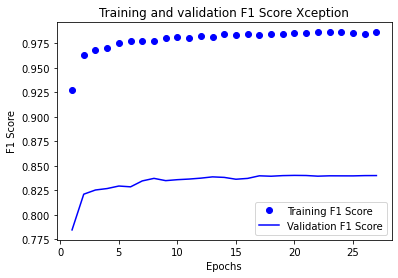

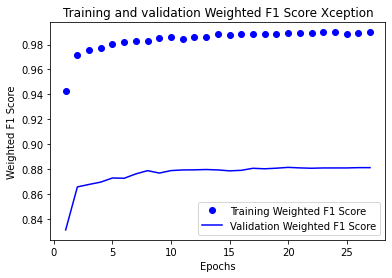

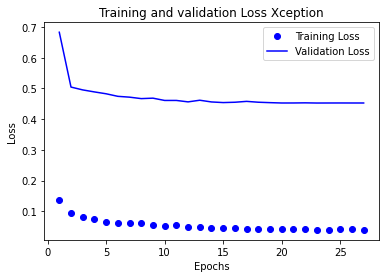

In [ ]:
# plot the training and validation macro F1-score, weighted F1-score, and loss. 

plot_training(27, history_x_tuning, 'Xception')

In [ ]:
# evaluate the model 

model_x.evaluate(test_data, return_dict=True)

141/141 [==============================] - 2s 16ms/step - loss: 0.4524 - f1_score: 0.8397 - weighted_f1: 0.8808 - accuracy: 0.8821


{'accuracy': 0.8821048140525818,
 'f1_score': array([0.97154313, 0.70967746, 0.7896996 , 0.8025478 , 0.8522728 ,
        0.8169014 , 0.7981438 , 0.7757256 , 0.84675324, 0.7835498 ,
        0.93711966, 0.9345794 , 0.8333333 , 0.9078499 , 0.835443  ],
       dtype=float32),
 'loss': 0.45241671800613403,
 'weighted_f1': 0.8807988166809082}

In [ ]:
# build  the transfer learning LSTM model using the Xception model as base.

input_shape = train_data.element_spec[0].shape
xception_model = xception(input_shape[1:])


x = (xception_model.get_layer('block3_pool').output) 
x = layers.BatchNormalization(axis=-1)(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Permute((2, 1, 3))(x)
x = layers.TimeDistributed(layers.Flatten())(x)
x = layers.LSTM(128, dropout=0.25, return_sequences=True)(x)
x = layers.LSTM(128, dropout=0.25)(x)
x = layers.Dense(CLASSES, kernel_regularizer=tf.keras.regularizers.l2(0.0001), activation='softmax')(x)

lstm_model_x = tf.keras.Model(inputs = xception_model.input, outputs = x)

lstm_model_x = compile(lstm_model_x, DEFAULT_METRICS)

83697664/83683744 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 63, 63, 32)   864         ['input_1[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 63, 63, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                             

In [ ]:
# train the model 

history_lstm_x = fit_model(lstm_model_x, train_data, val_data)

Epoch 1/100
563/563 [==============================] - 37s 31ms/step - loss: 1.0924 - f1_score: 0.5353 - weighted_f1: 0.6434 - accuracy: 0.6601 - val_loss: 0.7016 - val_f1_score: 0.7000 - val_weighted_f1: 0.7791 - val_accuracy: 0.7840 - lr: 0.0010
Epoch 2/100
563/563 [==============================] - 15s 26ms/step - loss: 0.6182 - f1_score: 0.7356 - weighted_f1: 0.8041 - accuracy: 0.8075 - val_loss: 0.5295 - val_f1_score: 0.7747 - val_weighted_f1: 0.8366 - val_accuracy: 0.8373 - lr: 0.0010
Epoch 3/100
563/563 [==============================] - 14s 25ms/step - loss: 0.4690 - f1_score: 0.8045 - weighted_f1: 0.8548 - accuracy: 0.8562 - val_loss: 0.4352 - val_f1_score: 0.8130 - val_weighted_f1: 0.8647 - val_accuracy: 0.8666 - lr: 0.0010
Epoch 4/100
563/563 [==============================] - 14s 25ms/step - loss: 0.3766 - f1_score: 0.8429 - weighted_f1: 0.8836 - accuracy: 0.8844 - val_loss: 0.4308 - val_f1_score: 0.8228 - val_weighted_f1: 0.8665 - val_accuracy: 0.8686 - lr: 0.0010
Epoch 5/

In [ ]:
# prepare model for fine tuning 

for layer in lstm_model_x.layers[14:]:
  layer.trainable = True

# reduce the model's default learning rate
adam = tf.keras.optimizers.Adam(learning_rate=1e-5)

# compile the model again
compile(lstm_model_x, DEFAULT_METRICS, optimizer=adam)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 63, 63, 32)   864         ['input_1[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 63, 63, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                              

In [ ]:
# train the model again for fine tuning the Xception layers. 

history_lstm_x_tuning = fit_model(lstm_model_x, train_data, val_data)

Epoch 1/100
563/563 [==============================] - 24s 35ms/step - loss: 0.3401 - f1_score: 0.8761 - weighted_f1: 0.9059 - accuracy: 0.8989 - val_loss: 0.3716 - val_f1_score: 0.8614 - val_weighted_f1: 0.8966 - val_accuracy: 0.8981 - lr: 1.0000e-05
Epoch 2/100
563/563 [==============================] - 19s 34ms/step - loss: 0.2085 - f1_score: 0.9128 - weighted_f1: 0.9348 - accuracy: 0.9351 - val_loss: 0.3156 - val_f1_score: 0.8745 - val_weighted_f1: 0.9079 - val_accuracy: 0.9087 - lr: 1.0000e-05
Epoch 3/100
563/563 [==============================] - 19s 34ms/step - loss: 0.1620 - f1_score: 0.9309 - weighted_f1: 0.9487 - accuracy: 0.9488 - val_loss: 0.2901 - val_f1_score: 0.8869 - val_weighted_f1: 0.9176 - val_accuracy: 0.9183 - lr: 1.0000e-05
Epoch 4/100
563/563 [==============================] - 19s 34ms/step - loss: 0.1459 - f1_score: 0.9395 - weighted_f1: 0.9561 - accuracy: 0.9562 - val_loss: 0.2770 - val_f1_score: 0.8926 - val_weighted_f1: 0.9224 - val_accuracy: 0.9230 - lr: 1.0

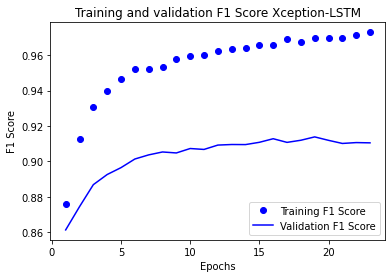

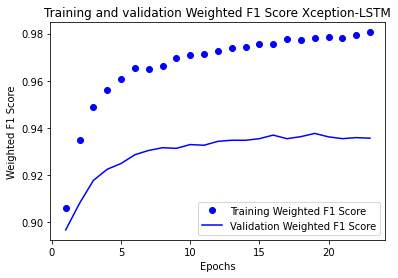

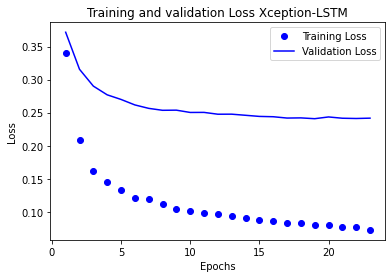

In [ ]:
# plot the training and validation macro F1-score, weighted F1-score, and loss

plot_training(23, history_lstm_x_tuning, 'Xception-LSTM')

In [ ]:
# evaluate the model. 

lstm_model_x.evaluate(test_data, return_dict=True)

141/141 [==============================] - 3s 17ms/step - loss: 0.2409 - f1_score: 0.9138 - weighted_f1: 0.9376 - accuracy: 0.9378


{'accuracy': 0.9378330111503601,
 'f1_score': array([0.9919029 , 0.8402778 , 0.9106383 , 0.8974359 , 0.92982453,
        0.8938548 , 0.8730512 , 0.8717948 , 0.91978604, 0.8679245 ,
        0.96865517, 0.96992487, 0.9056604 , 0.94863015, 0.9183673 ],
       dtype=float32),
 'loss': 0.24086862802505493,
 'weighted_f1': 0.9375979900360107}

## Tuning of the Best Model

In this section the hyperparameters of the best model, identified in the previous sections as the X-LSTM model, is tuned. 

First three different batch sizes were explored, the results is shown in the table below. 

Batch Size |Macro F1-score | Loss | Epochs
--- | --- | --- | ---
32 | 0.9091 | 0.2485 | 25
64 |  0.9182 | 0.2450 | 26
128 | 0.9123 | 0.2447 | 28

Next the number of LSTM layers and the number of units for each layer was explored. The table below summarizes the explored configurations and the model's performance. 

LSTM 1 | LSTM 2 | LSTM 3 | macro F1-score | Loss | Epochs 
--- | --- | --- | --- | --- | --- 
64 | - | - | 0.8703 |  0.3301 | 31
128 | - | - | 0.8828 |  0.2896 | 22
256 | - | - |  0.8924 | 0.2725 | 25
64 | 64 | - | 0.9045 | 0.2517 | 25
128 | 128 | - | 0.9182 |  0.2450 | 26
128 | 256 | - | 0.9136 | 0.2365 | 24
256 | 128 | - | 0.9235 | 0.2211 | 26
256 | 256 | - | 0.9112 | 0.2409 | 19
256 | 128 | 64 | 0.9107 | 0.2373 | 21
256 | 128 | 128 | 0.9120 | 0.2412 | 21
256 | 256 | 128 | 0.9102 | 0.2476 | 18




In [ ]:
# Create an instance of the X-LSTM model. 

input_shape = train_data.element_spec[0].shape
xception_model = xception(input_shape[1:])


x = (xception_model.get_layer('block3_pool').output) 
x = layers.BatchNormalization(axis=-1)(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Permute((2, 1, 3))(x)
x = layers.TimeDistributed(layers.Flatten())(x)
x = layers.LSTM(256, dropout=0.25, return_sequences=True)(x)
x = layers.LSTM(256, dropout=0.25, return_sequences=True)(x)
x = layers.LSTM(128, dropout=0.25)(x)
x = layers.Dense(CLASSES, kernel_regularizer=tf.keras.regularizers.l2(0.0001), activation='softmax')(x)

model = tf.keras.Model(inputs = xception_model.input, outputs = x)

model = compile(model, DEFAULT_METRICS)

83697664/83683744 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 63, 63, 32)   864         ['input_1[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 63, 63, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                             

In [ ]:
# train the model 

history = fit_model(model, train_data, val_data, batch_size=64)

Epoch 1/100
934/934 [==============================] - 47s 31ms/step - loss: 1.1344 - f1_score: 0.5183 - weighted_f1: 0.6299 - accuracy: 0.6436 - val_loss: 0.7931 - val_f1_score: 0.6529 - val_weighted_f1: 0.7484 - val_accuracy: 0.7496 - lr: 0.0010
Epoch 2/100
934/934 [==============================] - 26s 28ms/step - loss: 0.6851 - f1_score: 0.7050 - weighted_f1: 0.7819 - accuracy: 0.7848 - val_loss: 0.5737 - val_f1_score: 0.7516 - val_weighted_f1: 0.8250 - val_accuracy: 0.8227 - lr: 0.0010
Epoch 3/100
934/934 [==============================] - 27s 29ms/step - loss: 0.5221 - f1_score: 0.7749 - weighted_f1: 0.8349 - accuracy: 0.8361 - val_loss: 0.4746 - val_f1_score: 0.7936 - val_weighted_f1: 0.8561 - val_accuracy: 0.8544 - lr: 0.0010
Epoch 4/100
934/934 [==============================] - 27s 29ms/step - loss: 0.4300 - f1_score: 0.8124 - weighted_f1: 0.8632 - accuracy: 0.8638 - val_loss: 0.4672 - val_f1_score: 0.7994 - val_weighted_f1: 0.8561 - val_accuracy: 0.8542 - lr: 0.0010
Epoch 5/

In [ ]:
# prepare the model for fine tuning. 

for layer in model.layers[14:]:
  layer.trainable = True

# reduce the models default learning rate and compile it again. 
adam = tf.keras.optimizers.Adam(learning_rate=1e-5)
compile(model, DEFAULT_METRICS, optimizer=adam)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 63, 63, 32)   864         ['input_1[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 63, 63, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                              

In [ ]:
# fine tune the model by training it again. 

history_tuned = fit_model(model, train_data, val_data, batch_size=64)

Epoch 1/100
934/934 [==============================] - 41s 37ms/step - loss: 0.3220 - f1_score: 0.8843 - weighted_f1: 0.9133 - accuracy: 0.9135 - val_loss: 0.3737 - val_f1_score: 0.8686 - val_weighted_f1: 0.9067 - val_accuracy: 0.9071 - lr: 1.0000e-05
Epoch 2/100
934/934 [==============================] - 39s 42ms/step - loss: 0.1586 - f1_score: 0.9351 - weighted_f1: 0.9519 - accuracy: 0.9519 - val_loss: 0.3074 - val_f1_score: 0.8894 - val_weighted_f1: 0.9218 - val_accuracy: 0.9219 - lr: 1.0000e-05
Epoch 3/100
934/934 [==============================] - 38s 40ms/step - loss: 0.1162 - f1_score: 0.9527 - weighted_f1: 0.9655 - accuracy: 0.9655 - val_loss: 0.2847 - val_f1_score: 0.8970 - val_weighted_f1: 0.9278 - val_accuracy: 0.9278 - lr: 1.0000e-05
Epoch 4/100
934/934 [==============================] - 35s 37ms/step - loss: 0.0999 - f1_score: 0.9601 - weighted_f1: 0.9709 - accuracy: 0.9709 - val_loss: 0.2707 - val_f1_score: 0.9032 - val_weighted_f1: 0.9323 - val_accuracy: 0.9324 - lr: 1.0

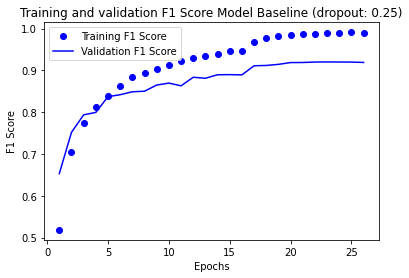

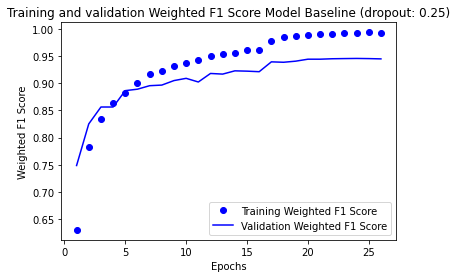

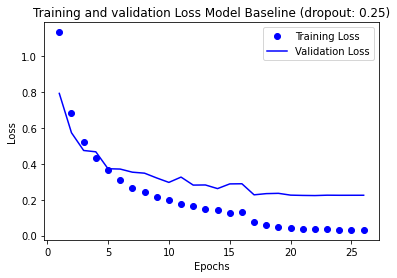

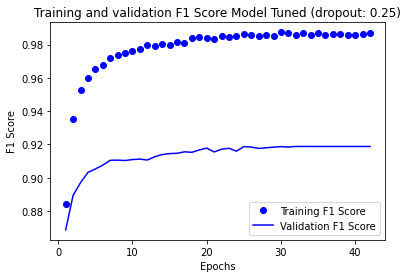

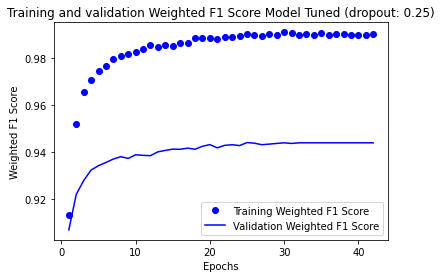

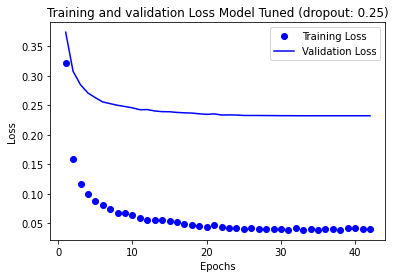

In [ ]:
# plot the training and validation macro F1-score, weighted F1-score, and loss
# both before and after fine tuning. 

plot_training(26, history, 'Model Baseline (dropout: 0.25)')
plot_training(42, history_tuned, 'Model Tuned (dropout: 0.25)')

In [ ]:
# evaluate the model. 

model.evaluate(test_data, return_dict=True)

234/234 [==============================] - 6s 22ms/step - loss: 0.2322 - f1_score: 0.9188 - weighted_f1: 0.9439 - accuracy: 0.9439


{'accuracy': 0.9438864588737488,
 'f1_score': array([0.99241495, 0.8522483 , 0.8594165 , 0.9230769 , 0.94616646,
        0.8938548 , 0.8979592 , 0.9053628 , 0.9254658 , 0.895288  ,
        0.9736034 , 0.97997653, 0.88235295, 0.94243073, 0.9118881 ],
       dtype=float32),
 'loss': 0.23218077421188354,
 'weighted_f1': 0.943880558013916}

## Tune Regulariztion and Evaluate Final Model (X-LSTM)

First four different values for the dropout rate in the two LSTM layers were tested. The table below shows the dropout rate values and the model's results.  

LSTM 1 dropout rate| LSTM 2 dropout rate | Macro F1-score | Loss
--- | --- | --- | ---
0.25 | 0.25 | 0.9235 | 0.2211
0.3 | 0.3 |  0.9219 | 0.2210
0.35 | 0.35 | 0.9152 | 0.2218
0.4 | 0.4 | 0.9139 | 0.2287

Next kernel regularization and activity regularization for the LSTM layers were explored. The tested configurations and the model's performance is summarized in the table below.  

LSTM 1 Kernel | LSTM 2 Kernel | LSTM 1 Activity | LSTM 2 Activity | Macro F1-score | Loss | Epochs 
--- | --- | --- | --- | --- | --- | --- 
L2: 0.01 | L2: 0.01 | - | - |  0.8880 | 0.4014 |57
L2: 0.001 | L2: 0.001 | - | - | 0.9187 |  0.3390 | 44
L2: 0.0001 | L2: 0.0001 | - | - | 0.9224 | 0.3595 | 36
L1L2: 0.0001 | L1L2: 0.0001 | - | - | 0.9066 | 0.4464 | 69
L2: 0.0001 | L2: 0.0001 | L2: 0.0001 | L2: 0.0001 | 0.9242 | 0.3482 | 32
L2: 0.00001 | L2: 0.00001 | L2: 0.00001 | L2: 0.00001 | 0.9124 | 0.3039 | 21


Then kernel regularization for the dense output layer was tuned. The explored values and the model's performance can be seen in the table below.

Dense Kernel | Macro F1-score | Loss | Epochs 
--- | --- | --- | ----
None |  0.9242 |  0.3482 | 32
L2: 0.001 | 9226 | 0.3364 | 44
L2: 0.0001 | 0.9283 | 0.3279 | 60



Lastly the final model was trained and evaluated, first using a dataset with log-mel spectrograms based on 5 second long audio clips. Then a new instance of the final model was trained and evaluated using a dataset with log-mel spectrograms based on 3 second long audio clips. The results is shown in the table below

Dataset | Macro F1-score | Loss
--- | --- | ---
5 second audios clips | 0.9280 | 0.3212
3 second audio clips | 0.9258 | 0.3232



In [ ]:
# Create an instance of the Xception model, all layers are set as non-trainable. 

input_shape = train_data.element_spec[0].shape
xception_model = xception(input_shape[1:])

# Connect wanted layers from the Xception model with a LSTM model. 

x = (xception_model.get_layer('block3_pool').output) 
x = layers.BatchNormalization(axis=-1)(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Permute((2, 1, 3))(x)
x = layers.TimeDistributed(layers.Flatten())(x)
x = layers.LSTM(256, 
                dropout=0.3, 
                kernel_regularizer=tf.keras.regularizers.L2(1e-4), 
                activity_regularizer=tf.keras.regularizers.L2(1e-4),
                return_sequences=True)(x)
x = layers.LSTM(128, 
                dropout=0.3, 
                kernel_regularizer=tf.keras.regularizers.L2(1e-4),
                activity_regularizer=tf.keras.regularizers.L2(1e-4))(x)
x = layers.Dense(CLASSES, kernel_regularizer=tf.keras.regularizers.l2(1e-4), activation='softmax')(x)

x_model = tf.keras.Model(inputs = xception_model.input, outputs = x)

# compile the model 
x_model = compile(x_model, DEFAULT_METRICS)
    

83697664/83683744 [==============================] - 3s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 63, 63, 32)   864         ['input_1[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 63, 63, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                             

In [ ]:
# train the model 

x_history = fit_model(x_model, train_data, val_data, batch_size=64)

Epoch 1/100
934/934 [==============================] - 44s 28ms/step - loss: 1.2748 - f1_score: 0.5574 - weighted_f1: 0.6571 - accuracy: 0.6704 - val_loss: 0.9497 - val_f1_score: 0.6776 - val_weighted_f1: 0.7649 - val_accuracy: 0.7684 - lr: 0.0010
Epoch 2/100
934/934 [==============================] - 24s 26ms/step - loss: 0.8963 - f1_score: 0.7190 - weighted_f1: 0.7900 - accuracy: 0.7927 - val_loss: 0.8125 - val_f1_score: 0.7455 - val_weighted_f1: 0.8192 - val_accuracy: 0.8207 - lr: 0.0010
Epoch 3/100
934/934 [==============================] - 25s 27ms/step - loss: 0.7855 - f1_score: 0.7708 - weighted_f1: 0.8308 - accuracy: 0.8322 - val_loss: 0.7356 - val_f1_score: 0.7855 - val_weighted_f1: 0.8486 - val_accuracy: 0.8497 - lr: 0.0010
Epoch 4/100
934/934 [==============================] - 24s 26ms/step - loss: 0.7170 - f1_score: 0.8067 - weighted_f1: 0.8578 - accuracy: 0.8586 - val_loss: 0.7259 - val_f1_score: 0.7938 - val_weighted_f1: 0.8562 - val_accuracy: 0.8536 - lr: 0.0010
Epoch 5/

In [ ]:
# prepare the model for fine tuning

for layer in x_model.layers[14:]:
  layer.trainable = True

# reduce the model's default learning rate and compile the model.
adam = tf.keras.optimizers.Adam(learning_rate=1e-5)
x_model = compile(x_model, DEFAULT_METRICS, optimizer=adam)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 63, 63, 32)   864         ['input_1[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 63, 63, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                              

In [ ]:
# fine tune the model by training it once again. 

history_tuned = fit_model(x_model, train_data, val_data, batch_size=64)

Epoch 1/100
934/934 [==============================] - 44s 42ms/step - loss: 0.3982 - f1_score: 0.9074 - weighted_f1: 0.9314 - accuracy: 0.9263 - val_loss: 0.4422 - val_f1_score: 0.8878 - val_weighted_f1: 0.9210 - val_accuracy: 0.9211 - lr: 1.0000e-05
Epoch 2/100
934/934 [==============================] - 39s 42ms/step - loss: 0.2574 - f1_score: 0.9476 - weighted_f1: 0.9615 - accuracy: 0.9615 - val_loss: 0.3997 - val_f1_score: 0.8969 - val_weighted_f1: 0.9278 - val_accuracy: 0.9279 - lr: 1.0000e-05
Epoch 3/100
934/934 [==============================] - 38s 41ms/step - loss: 0.2266 - f1_score: 0.9620 - weighted_f1: 0.9720 - accuracy: 0.9721 - val_loss: 0.3781 - val_f1_score: 0.9020 - val_weighted_f1: 0.9315 - val_accuracy: 0.9316 - lr: 1.0000e-05
Epoch 4/100
934/934 [==============================] - 33s 36ms/step - loss: 0.2105 - f1_score: 0.9674 - weighted_f1: 0.9760 - accuracy: 0.9761 - val_loss: 0.3640 - val_f1_score: 0.9099 - val_weighted_f1: 0.9376 - val_accuracy: 0.9377 - lr: 1.0

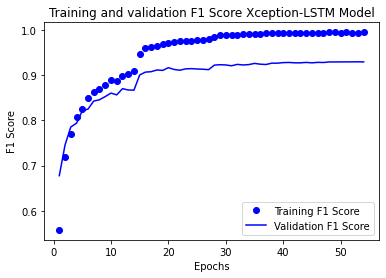

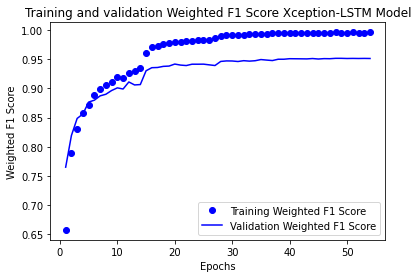

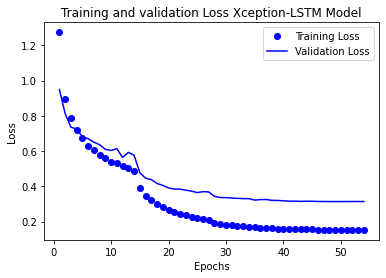

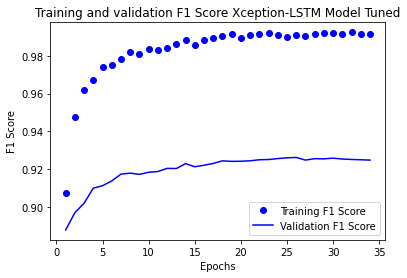

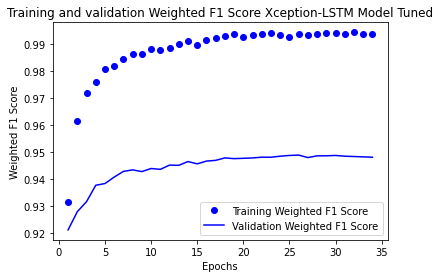

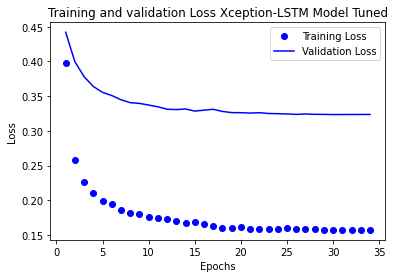

In [ ]:
# plot the training and validation macro F1-score, weighted F1-score, and loss
# both before and after fine tuning. 

plot_training(54, x_history, 'Xception-LSTM Model')
plot_training(34, history_tuned, 'Xception-LSTM Model Tuned')

In [ ]:
# evaluate the model 

x_model.evaluate(test_data, return_dict=True)

234/234 [==============================] - 5s 19ms/step - loss: 0.3235 - f1_score: 0.9258 - weighted_f1: 0.9487 - accuracy: 0.9487


{'accuracy': 0.948707640171051,
 'f1_score': array([0.9924261 , 0.8808511 , 0.87096775, 0.92395   , 0.94873875,
        0.89330924, 0.91124254, 0.9107982 , 0.92621666, 0.89736843,
        0.98092306, 0.9822904 , 0.89411765, 0.95289075, 0.9209039 ],
       dtype=float32),
 'loss': 0.32348722219467163,
 'weighted_f1': 0.9487140774726868}

In [ ]:
y_true = []
y_pred = []

# predict labels for each batch in the test dataset 
for batch in test_data:
  pred = x_model.predict(batch[0])
  y_pred.append(np.argmax(pred, axis=1))
  y_true.append(np.argmax(batch[1], axis=1))

In [ ]:
# get the indices of the true labels in y_true and
# reshape y_true and y_pred into 1D tensors 

labels = tf.concat([np.argmax(y, axis=1) for x, y in test_data], axis=0)
predictions = tf.concat([x for x in y_pred], axis=0)

In [ ]:
# generate a confusion matrix of the predicted and true labels. 

confusion_matrix = tf.math.confusion_matrix(
    labels,
    predictions,
    CLASSES).numpy()

In [ ]:
# code from:  https://androidkt.com/keras-confusion-matrix-in-tensorboard/
# Normalize the values in the confusion matrix and create a DataFrame to add
# the label names to the matrix. 

confusion_matrix_norm = np.around(confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(confusion_matrix_norm, index = CLASS_NAMES, columns = CLASS_NAMES)

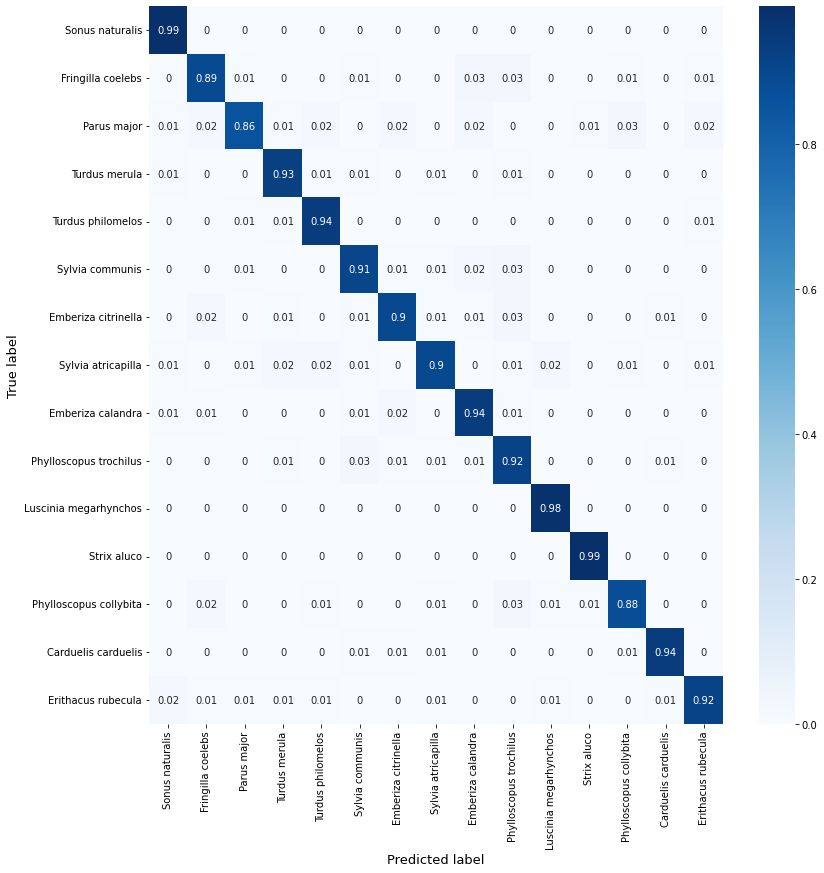

In [ ]:
# code from: https://androidkt.com/keras-confusion-matrix-in-tensorboard/
# plot the generated confusion matrix. 

figure = plt.figure(figsize=(12, 12))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label', fontsize=13)
plt.xlabel('Predicted label', fontsize=13)
plt.show()